In [17]:
# Important imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
from os import listdir
from sklearn.preprocessing import  LabelBinarizer
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from keras.optimizers import Adam
from PIL import Image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, LeakyReLU, BatchNormalization
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Configure TensorFlow to use multiple threads
tf.config.threading.set_intra_op_parallelism_threads(8)
tf.config.threading.set_inter_op_parallelism_threads(8)

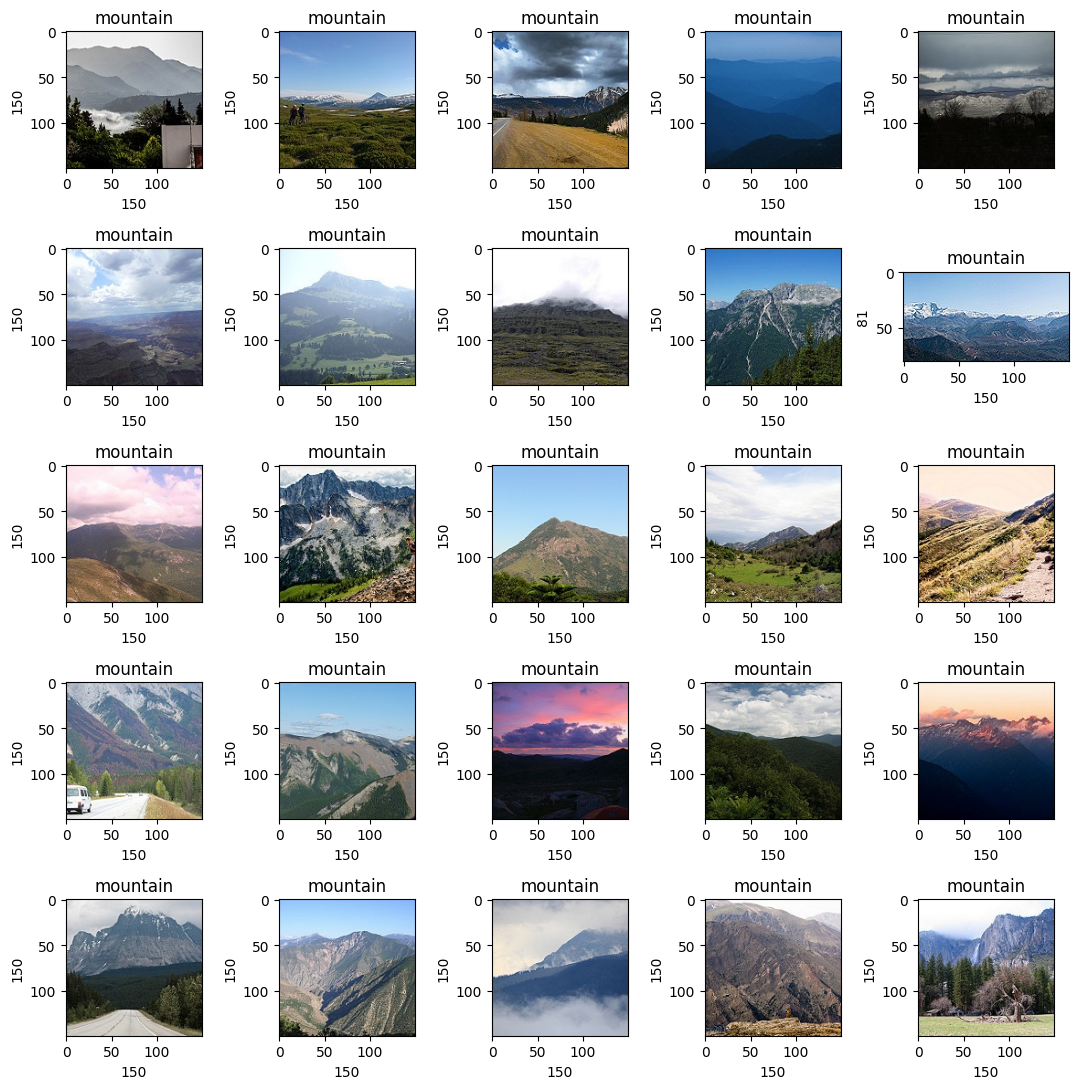

In [19]:
# Plotting 25 images to check dataset
plt.figure(figsize=(11,11))
path = r"C:\Users\Shamiur Rahman\Desktop\Intel Image Dataset\mountain"
for i in range(1,26):
    plt.subplot(5,5,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(listdir(path))))
    plt.imshow(rand_img)
    plt.title('mountain')
    plt.xlabel(rand_img.shape[1], fontsize = 10)
    plt.ylabel(rand_img.shape[0], fontsize = 10)

In [21]:
# Setting root directory path and creating empty list
dir = r"C:\Users\Shamiur Rahman\Desktop\Intel Image Dataset"
root_dir = listdir(dir)
image_list, label_list = [], []

In [23]:
# Reading and converting image to numpy array
for directory in root_dir:
  for files in listdir(f"{dir}/{directory}"):
    image_path = f"{dir}/{directory}/{files}"
    image = Image.open(image_path)
    image = image.resize((150,150)) # All images does not have same dimension
    image = img_to_array(image)
    image_list.append(image)
    label_list.append(directory)

In [25]:
# Visualize the number of classes count
label_counts = pd.DataFrame(label_list).value_counts()
label_counts

0        
glacier      553
mountain     525
sea          510
street       501
forest       474
buildings    437
Name: count, dtype: int64

In [27]:
# Checking count of classes
num_classes = len(label_counts)
num_classes

6

In [29]:
# Checking x data shape
np.array(image_list).shape

(3000, 150, 150, 3)

In [31]:
# Checking y data shape
label_list = np.array(label_list)
label_list.shape

(3000,)

In [33]:
# Splitting dataset into test and train
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, random_state = 10) 

In [35]:
# Normalize and reshape data
x_train = np.array(x_train, dtype=np.float16) / 225.0
x_test = np.array(x_test, dtype=np.float16) / 225.0
x_train = x_train.reshape( -1, 150,150,3)
x_test = x_test.reshape( -1, 150,150,3)

In [37]:
# Binarizing labels
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)
print(lb.classes_)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


In [43]:
# Splitting the training data set into training and validation data sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

A network architecture for the model will be created using various types of layers based on their features. BatchNormalization, which standardizes the inputs to a layer for each mini-batch, will be utilized. LeakyReLU will be applied to allow small negative values when the input is less than zero. Conv2D will be used to create a convolutional kernel that is convolved with the input layer to produce the output tensor. MaxPooling2D, a downsampling technique, will be employed to extract the maximum value over the window defined by the pool size. The input will then be flattened to create a 1D output using the Flatten layer. Finally, the Dense layer will produce the output as the dot product of the input and kernel. In the last layer, the Softmax activation function will be used since it is a multi-class classification problem.

In [45]:
# Creating model architecture
model = Sequential([
        Conv2D(16, kernel_size = (3,3), input_shape = (150,150,3)),
        BatchNormalization(),
        LeakyReLU(),
          
        Conv2D(32, kernel_size = (3,3)),
        BatchNormalization(),
        LeakyReLU(),
        MaxPooling2D(5,5),
        
        Conv2D(64, kernel_size = (3,3)),
        BatchNormalization(),
        LeakyReLU(),
        
        Conv2D(128, kernel_size = (3,3)),
        BatchNormalization(),
        LeakyReLU(),
        MaxPooling2D(5,5),

        Flatten(),
    
        Dense(64),
        Dropout(rate = 0.2),
        BatchNormalization(),
        LeakyReLU(),
        
        Dense(32),
        Dropout(rate = 0.2),
        BatchNormalization(),
        LeakyReLU(),
    
        Dense(16),
        Dropout(rate = 0.2),
        BatchNormalization(),
        LeakyReLU(1),
    
        Dense(6, activation = 'softmax')    
        ])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 148, 148, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 148, 148, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 146, 146, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 146, 146, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 146, 146, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 29, 29, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 27, 27, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 27, 27, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 27, 27, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │             

 Total params: 306,422 (1.17 MB)

 Trainable params: 305,718 (1.17 MB)

 Non-trainable params: 704 (2.75 KB)

In [47]:
# Compiling model
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0005),metrics=['accuracy'])

In [49]:
# Training the model
epochs = 70
batch_size = 128
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (x_val, y_val))

Epoch 1/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.3191 - loss: 1.7914 - val_accuracy: 0.2109 - val_loss: 1.7477
Epoch 2/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.5462 - loss: 1.2389 - val_accuracy: 0.2057 - val_loss: 1.7826
Epoch 3/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.5890 - loss: 1.0980 - val_accuracy: 0.1797 - val_loss: 1.8357
Epoch 4/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.6478 - loss: 0.9718 - val_accuracy: 0.1797 - val_loss: 1.8991
Epoch 5/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.6836 - loss: 0.8914 - val_accuracy: 0.1797 - val_loss: 1.9507
Epoch 6/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.7193 - loss: 0.8328 - val_accuracy: 0.1797 - val_loss: 2.0740
Epoch 7/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.7607 - loss: 0.7311 - val_accuracy: 0.1797 - val_loss: 2.0677
Epoch 8/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.7771 - loss: 0.6992 - val_accuracy: 0.1797 - val_loss:

In [51]:
# Saving model
model.save(r"C:\Users\Shamiur Rahman\Desktop\Intel Image Dataset\model.keras")